### Data Science for Humanities 1
## Session: Explorative Analysis 
### Part 2: Clustering (and the vector space model)
#### Winter term 22/23
##### Prof. Goran Glavaš, Lennart Keller

## Goals:

After this session you'll know about:

* Thinking of your data as vectors in an $N$-dimensional space
* How to measure distances in vector spaces
* What the goal of clustering is
* The most commonly used clustering algorithms
* How to cluster your data using `Scikit-Learn`

## Vector space model

For this session, we'll assemble a dataset based on Wikipedia articles using our scraper from session 4.

We download some articles about Biology and Computer Science like so:

In [1]:
import wikipedia
import requests
import pandas as pd
from tqdm.auto import tqdm

HEADERS = {'User-Agent': 'DataScienceBot/0.0 (https://example.org/DataScienceBot/; DataScienceBot@example.org)'}

def build_wiki_dataset(query: str, max_results: int = 100):
    
    data = []
    progress_bar = tqdm(wikipedia.search(query, results=max_results))
    for result in progress_bar:
        progress_bar.set_description(f"Downloading page {result}")
        try:
            page = wikipedia.page(result)
            page_name = page.url.split("/")[-1]
            edit_request = requests.get(
                f"https://en.wikipedia.org/w/rest.php/v1/page/{page_name}/history/counts/edits?",
                headers=HEADERS
            )
            num_edits = edit_request.json()["count"]
            num_views_request = requests.get(
                f"https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia.org/all-access/all-agents/{page_name}/daily/2000010100/2022112700",
                headers=HEADERS
            )
            num_views = sum([entry["views"] for entry in num_views_request.json()["items"]])
        
        except Exception:
            # We discard the page and move on
            continue

        page_data = {
            "url": page.url,
            "title": page.title,
            "summary": page.summary,
            "text": page.content,
            "num_views": num_views,
            "num_edits": num_edits,
            "categories": ", ".join(page.categories),
            "revision_id": page.revision_id
        }
        
        data.append(page_data)
    
    df = pd.DataFrame.from_records(data)
    return df

In [2]:
'''import pandas as pd
#from wiki import build_wiki_dataset

articles_bio = build_wiki_dataset("biology", max_results=50)
articles_bio["topic"] = "biology"   # Add a label describing the topic

articles_cs = build_wiki_dataset("computer science", max_results=50)
articles_cs["topic"] = "cs"

articles_dataset = pd.concat((articles_bio, articles_cs))

articles_dataset.to_csv("bio-cs-wiki-dataset.csv", index=False)'''

'import pandas as pd\n#from wiki import build_wiki_dataset\n\narticles_bio = build_wiki_dataset("biology", max_results=50)\narticles_bio["topic"] = "biology"   # Add a label describing the topic\n\narticles_cs = build_wiki_dataset("computer science", max_results=50)\narticles_cs["topic"] = "cs"\n\narticles_dataset = pd.concat((articles_bio, articles_cs))\n\narticles_dataset.to_csv("bio-cs-wiki-dataset.csv", index=False)'

After, we saved our dataset to disk there is no need to execute the time consuming scraping each time we execute the notebook.

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# In this notebook we use some methods that rely on random initialization,
# so we fix the random seed, to get reproducible results.
from random import seed
np.random.seed(42), seed(42)

articles_dataset= pd.read_csv("bio-cs-wiki-dataset.csv")
articles_dataset

,url,title,summary,text,num_views,num_edits,categories,revision_id,topic
0,https://en.wikipedia.org/wiki/Geology,Geology,"Geology (from Ancient Greek γῆ (gê) 'earth', ...","Geology (from Ancient Greek γῆ (gê) 'earth', ...",4234884,3290,"All articles with failed verification, Article...",1134347625,biology
1,https://en.wikipedia.org/wiki/Molecular_biology,Molecular biology,Molecular biology is the branch of biology th...,Molecular biology is the branch of biology th...,2143110,1453,"Articles with BNE identifiers, Articles with B...",1124222343,biology
2,https://en.wikipedia.org/wiki/Family_(biology),Family (biology),"Family (Latin: familia, plural familiae) is on...","Family (Latin: familia, plural familiae) is on...",2773053,921,"Articles containing French-language text, Arti...",1133677852,biology
3,https://en.wikipedia.org/wiki/Taxonomy_(biology),Taxonomy (biology),"In biology, taxonomy (from Ancient Greek τάξι...","In biology, taxonomy (from Ancient Greek τάξι...",9881050,3868,"All articles lacking reliable references, All ...",1133363688,biology
4,https://en.wikipedia.org/wiki/Cell_(biology),Cell (biology),The cell is the basic structural and functiona...,The cell is the basic structural and functiona...,9210652,4701,"1665 in science, Articles containing Latin-lan...",1133996848,biology
...,...,...,...,...,...,...,...,...,...
89,https://en.wikipedia.org/wiki/Session_(compute...,Session (computer science),In computer science and networking in particul...,In computer science and networking in particul...,688210,294,"All articles needing additional references, Ar...",1132147435,cs
90,https://en.wikipedia.org/wiki/Expression_(comp...,Expression (computer science),"In computer science, an expression is a syntac...","In computer science, an expression is a syntac...",424447,130,"Articles with short description, Evaluation st...",1122286456,cs
91,https://en.wikipedia.org/wiki/Circuit_(compute...,Circuit (computer science),"In theoretical computer science, a circuit is ...","In theoretical computer science, a circuit is ...",83709,39,"Circuit complexity, Theory of computation",1130988638,cs
92,https://en.wikipedia.org/wiki/Philosophy_of_co...,Philosophy of computer science,The philosophy of computer science is concerne...,The philosophy of computer science is concerne...,203337,150,"Articles with short description, Philosophy of...",1114652614,cs


To encode our texts into numbers, we use the `CountVectorizer` class offered by `Scikit-Learn` (more on that library later).

It works similar to the BagOfWord-encoder class you already implemented as homework, but comes with additional useful properties.


In [4]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(
    max_features=500,  # We only want to use the 500 most frequent terms
    stop_words="english",  # Filter out English stopwords (i.e., non-content functional terms like "and", "the", ...
    lowercase=True,  # Convert all characters to lower cases ones
    ngram_range=(1, 3)  # We not only want to count single words but also word-level n-grams up to a length of 3
)

freqs = cv.fit_transform(articles_dataset.text)
freqs = freqs.todense()  # For educational purposes, we convert the matrix of word counts from sparse into dense format.

#print(cv.vocabulary_)
freqs

matrix([[ 0,  4,  0, ...,  3,  0, 10],
        [ 2,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        ...,
        [ 1,  0,  0, ...,  0,  0,  0],
        [ 1,  1,  1, ...,  1,  0,  0],
        [ 0,  0,  0, ...,  1,  0,  0]], dtype=int64)

To make the texts comparable regardless of their individual length, we compute the relative word frequencies

In [5]:
freqs = freqs / freqs.sum(axis=1).reshape(-1, 1) #rel. häufigkeit pro zeile also pro buch innerhalb der 94 bücher
print(freqs)
print(np.allclose(freqs.sum(axis=1), 1)) #np.allclose() prüft ob die 94 bücher innerhalb einer wertespezifischen toleranz liegen

[[0.         0.00339559 0.         ... 0.00254669 0.         0.00848896]
 [0.00241838 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.00520833 0.         0.         ... 0.         0.         0.        ]
 [0.00564972 0.00564972 0.00564972 ... 0.00564972 0.         0.        ]
 [0.         0.         0.         ... 0.00735294 0.         0.        ]]
True


As we've already learned our document term-matrix now consists of 94 rows because our dataset contains 94 texts, and each row has 5000 entries (=> columns in the matrix) each one representing the frequency of one of the 5000 most frequent words (or n-grams) of the corpus in this text.

If we slice a row out of the matrix, we'll get a vector:

In [6]:
freqs.shape

(94, 500)

In essence, you can think of a vector as a list of numbers where each entry in the list is called a dimension.

The total number of entries in the vector determines its dimensionality.

So text at index 23 (like all the other texts) is now described using a 500-dimensional vector.

As you might have learned in school, a great way to imagine vectors is to think of them as points in space.

Because the space our text-vectors reside in is 500-dimensional it's impossible to imagine them visually, but luckily the same things that apply to points in a three- or two-dimensional space, also apply to any other n-dimensional space.

In [7]:
ind = 23 #text nr. 24 (0-23) als vektor mit häufigkeitswerten
print(freqs[ind])

[[0.00514933 0.         0.         0.         0.         0.
  0.         0.         0.         0.00102987 0.         0.0030896
  0.00205973 0.         0.         0.00102987 0.0030896  0.
  0.         0.         0.         0.         0.         0.
  0.00102987 0.         0.00411946 0.         0.         0.
  0.         0.         0.         0.         0.00514933 0.
  0.00720906 0.00411946 0.         0.         0.         0.
  0.         0.01544799 0.         0.         0.00205973 0.
  0.         0.         0.00205973 0.         0.01647786 0.
  0.0092688  0.00205973 0.00102987 0.01853759 0.01132853 0.
  0.         0.         0.         0.0030896  0.         0.
  0.         0.         0.         0.         0.         0.
  0.00102987 0.         0.         0.         0.00102987 0.00205973
  0.         0.         0.         0.         0.01235839 0.
  0.00205973 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.00102987 0

### Distance functions

Now that we've converted our texts into vector representations we can leverage a huge set of vector-based operations to investigate them.

The most fundamental operation to compare vectors (aka points in space) is to measure the distance between them.

There are several measures to quantify the distance between two points, with the most intuitive being the Euclidean distance:

$$
d_E(q, p) = \sqrt{\sum_{i=1}^{N} (q_i - p_i)^2}
$$

The Euclidean distance measures the length of a straight line drawn from point $q$ to point $p$.

But there are additional metrics that depending on the vector space they operate on might bear other notions of distance


https://miro.medium.com/max/1400/1*FTVRr_Wqz-3_k6Mk6G4kew.png


If operating on texts, the *cosine similarity* is useful, because it is based on the angle between any two vectors, and thus not affected by the vector's magnitude, making it insensitive against differences in text lengths. Cosine similarity between two vectors is the cosine of the angle between them and is computed as follows: 

$$
\mathit{cos}(q, p) = \frac{\sum_{i=1}^{N}{q_i \cdot p_i}}{\sqrt{\sum_{i=1}^{N}{q_i^2}} \cdot \sqrt{\sum_{i=1}^{N}{p_i^2}}}
$$

Cosine distance is then computed as 1 minus the cosine similarity: $$ d_C(q, p) = 1 - \mathit{cos}(q, p) $$

Let's use the cosine similarity to get a more global overview of our texts.

To do this we create a `(n_texts, n_texts)` similarity matrix containing the similarity from each text to all other texts.

Note that, computing all sorts of from-each-to-each relations or measures is generally computationally expensive and might require large amounts of time, memory or computing.

But because our dataset is fairly small, we won't run into any of those issues.

First, we leverage some `scipy` features to compute the raw distance matrix:

In [8]:
from scipy.spatial.distance import pdist, squareform, cosine 

distance_matrix = squareform(pdist(freqs, metric=cosine)) #squareform necessary to compare vectors
distance_matrix.shape

(94, 94)

Additionally, we create a new `Dataframe` for the matrix and add the content-labels (bio, computer science) to the `Dataframe`

In [9]:
distance_matrix = pd.DataFrame(data=distance_matrix, columns=articles_dataset["topic"], index=articles_dataset["topic"]) #"topic" ist die beschreibung bio oder cs

<AxesSubplot:xlabel='topic', ylabel='topic'>

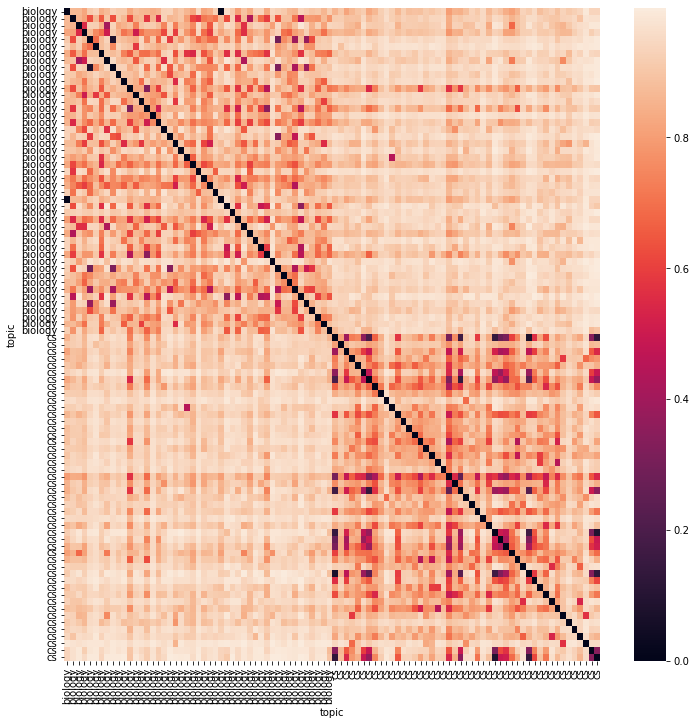

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12)) #subplot: contains many smaller plots
sns.heatmap(data=distance_matrix, ax=ax, xticklabels=True, yticklabels=True)

Darker colors indicate a smaller distance between any points, so it becomes obvious, that texts from within each category, are closer to another than to texts from the other category.

To not only visualize the distances graphically, we can also apply our descriptive statistics toolset to it:

In [11]:
distance_matrix.query("topic == 'cs'")[[c for c in distance_matrix.columns if c == "cs"]].melt().describe() #anders: alle spalten => melt(): reduziert auf durchschnitt

,value
count,103823.000000
mean,0.791179
std,0.189086
min,0.000000
25%,0.747636
50%,0.847987
75%,0.910509
max,0.989235


In [12]:
distance_matrix.query("topic == 'biology'")[[c for c in distance_matrix.columns if c == "biology"]].melt().describe()

,value
count,103823.000000
mean,0.805992
std,0.171160
min,0.000000
25%,0.760978
50%,0.856248
75%,0.910813
max,0.986379


By only looking at the intra-topic distances, we see that both groups seem to be similar concerning their internal structure. 

Also, texts about computer science seem to be a little more similar to each other than those about biology.

By looking at the distance matrix, we can also see that there is a small group of (around 3) texts which are relatively close to other category.

Let's find out what they are about:

In [13]:
articles_dataset.iloc[
    distance_matrix.query("topic == 'biology'")[[c for c in distance_matrix.columns if c == "cs"]].mean(axis=1).argsort()
].head(5)

,url,title,summary,text,num_views,num_edits,categories,revision_id,topic
11,https://en.wikipedia.org/wiki/Computational_bi...,Computational biology,Computational biology refers to the use of dat...,Computational biology refers to the use of dat...,925265,480,"All articles with unsourced statements, Articl...",1131620059,biology
14,https://en.wikipedia.org/wiki/Systems_biology,Systems biology,Systems biology is the computational and mathe...,Systems biology is the computational and mathe...,786795,1253,"All articles with style issues, All articles w...",1129297987,biology
35,https://en.wikipedia.org/wiki/Mathematical_and...,Mathematical and theoretical biology,"Mathematical and theoretical biology, or bioma...","Mathematical and theoretical biology, or bioma...",651088,897,"All articles lacking reliable references, All ...",1123208062,biology
22,https://en.wikipedia.org/wiki/Homology_(biology),Homology (biology),"In biology, homology is similarity due to shar...","In biology, homology is similarity due to shar...",1844028,1229,"All articles with unsourced statements, Articl...",1133813026,biology
3,https://en.wikipedia.org/wiki/Taxonomy_(biology),Taxonomy (biology),"In biology, taxonomy (from Ancient Greek τάξι...","In biology, taxonomy (from Ancient Greek τάξι...",9881050,3868,"All articles lacking reliable references, All ...",1133363688,biology


## Clustering

Clustering is the task of automatically finding groups (aka clusters) of similar objects in your data.

Suppose, for example, we wouldn't have labels for our wiki dataset, we expect clustering to reveal that there are two types of articles.

More detailed the objective of clustering is two-fold:

Clustering is the task of finding a finite number of clusters in a dataset, such that:

- The objects in a cluster are as similar as possible.
- Objects from different clusters are as dissimilar as possible.

Clustering is the most widely used technique of unsupervised learning.

Unsupervised learning is a category of techniques that find patterns in your data without requiring manual supervision (aka labelling of objects as examples).

There are many different approaches to clustering, to broadly categorize them we can apply a differentiation based on their notion of similarity.

##### Types of clustering algorithms

* Distance-based clustering
  * Representative-based clustering (K-Means, K-Medoids)
    * Approach: Learn representatives for each cluster
  * Density-based clustering (DB-Scan)
    * Approach: Infer a clustering by identifying densely filled regions within a vector space
* Hierarchical clustering
  * Approach: Strongly related to distance-based clustering, but instead of finding a single clustering a hierarchy of different clusterings is learned
* Generative Clustering
  * Approach: Estimate a set of distributions that could have generated the observed data/ clusters (Gaussian-Mixture-Models)

Additionally, there is one important practical difference between clustering algorithms: How they find the number of clusters.

Most clustering techniques treat the number of clusters as a hyperparameter, and the user has to decide upfront how many clusters there are (or they want to find).

A small set of clustering techniques can infer the number of clusters. But in those cases, the number of found clusters highly depends on other hyperparameters, so it should also be taken with caution.

## Intermission: `Scikit-Learn`

`Scikit-Learn` is Python's most popular library for all sorts of _traditional_ (i.e., non-deep-learning) machine learning.

It covers a wide variety of fundamental and robust models, and algorithms into a package with a coherent API, that alleviates quickly replacing or updating parts of an ML-pipeline.

Additionally, it provides tools for feature extraction and evaluation.

Like `pandas`, `numpy` or `seaborn` you have to install it manually

#### Installation
```bash
pip | conda install scitkit-learn
```

#### Import

In constrast, to the other packages we already used, you rarely need everything that `Scikit-Learn` offers at once.

So instead of importing the whole library you'll import only those parts you need:

```python
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
...
```

As you can see the library is split up into multiple submodules.

#### API

Most of `Scikit-Learns´ models and feature extraction routines come es classes.

These classes follow the same API.

##### Fitting a machine learning model



For example, if you want to train a classifier to distinguish between texts about computer science or biology, you simply import the type of classifier you want to use, and train it with one convenient method-call:

__Note:__ For now don't worry about what we are doing in this example, this example only serves the purpose of showing how the API works!

In [14]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(np.asarray(freqs), articles_dataset["topic"])

LogisticRegression()

By calling the fit method and passing a set of articles in DTM format and their categories (=> labels) as arguments, the model is trained to differentiate texts about CS and Biology.

After the training is finished, the model may expose new attributes that end with an underscore `_`

Those are the parameters that have been learned during training:

In [15]:
classifier.coef_.shape

(1, 500)

After a model has been trained on a dataset, we can use the `predict` method to classify new data:

In [16]:
my_text = "In this essay, I want to prove that fungi are animals!"
feats = (cv.transform([my_text]))
print(feats.shape)

print(classifier.predict(feats)) #classifier von vorher hier verwendet als vergleich zum eigenen Text: ausgabe: bio passt am besten
print(classifier.predict_proba(feats)) #gibt den score aus: predict probabilities

(1, 500)
['biology']
[[0.55951398 0.44048602]]


Using a coherent API that all models follows allows to quickly exchange parts without having to rewrite a lot of code!

If want to use another classifer, the same logic applies:

In [17]:
from sklearn.svm import LinearSVC

classifier = LinearSVC()
classifier.fit(np.asarray(freqs), articles_dataset["topic"])
my_text = "In this essay, I show that P equals NP if the algorithm is written in TurboPascal."
classifier.predict(cv.transform([my_text]))
#achtung: proba ausgeben hier nicht möglich!

array(['cs'], dtype=object)

##### Preprocessing

`Scikit-Learn` offers a variety of routines to convert your data into features.

We already used the `CountVectorizer` which takes a collection of texts and builds a document term matrix.

Like the actual models, these preprocessing steps are implemented as classes and also follow a coherent API (which is even similar to the models API):

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

texts = ["Alpha sagt Beta", "Beta sagt Alpha"] #texts = ["Alpha sagt hallo", "Beta sagt sagt Alpha"]
count_vec = CountVectorizer()

count_vec.fit(texts)
count_vec.vocabulary_ #ausgabe: alphabetische sortierung stelle 0-3

{'alpha': 0, 'sagt': 2, 'beta': 1}

Similar to the models, preprocessing routines also often have to be fitted to your data.

For example, during fitting, the `CountVectorizer` builds the vocabulary which is later used to fill the document-term matrix.

After `CountVectorizer` is fitted, we obviously can't use it to predict new data, instead, we use it to transform the texts into a document-term matrix:

In [19]:
X = count_vec.transform(texts)
X.todense() #spalten: alpha - beta - hallo - sagt

matrix([[1, 1, 1],
        [1, 1, 1]], dtype=int64)

Because the fitting and transformation of ("training") data is often used subsequently, there is also a shortcut that does both steps with just one call:

In [20]:
X = count_vec.fit_transform(texts)
count_vec.vocabulary_, X.shape, X.todense()

({'alpha': 0, 'sagt': 2, 'beta': 1},
 (2, 3),
 matrix([[1, 1, 1],
         [1, 1, 1]], dtype=int64))

_Note:_ If you want to encode more texts into a document-term matrix of the same format (i.e., same vocabulary), you can't use `fit_transform` because it'll overwrite the old vocabulary: in that case, just use `transform`!

### KMeans

Due to its conceptual and technical simplicity, KMeans is the most widely applied clustering algorithm.

Originally developed independently by two groups, it's also known under the name of "clustering via variance reduction".

Its outline is simple:

* The number of clusters $K$ is a hyperparameter and has to be set by the user
* For each cluster, we want to find a centroid. A centroid is the middle point of the cluster meaning that it has a minimal distance to all clusters members
* The clustering is created by assigning each point in the dataset to a cluster/ centroid.

The goal of KMeans is to find an optimal set of $K$ centroids given a dataset.

The general algorithm for that is simple, and can neatly be expressed in pseudocode:

```
1. Initialize K centroids randomly
2. Compute initial clustering => Assignment of each point to its nearest centroid
3. Repeat until point-to-cluster assignment does not change anymore:
4.      Compute new set of centroids by taking the average of all points of a cluster
5.      Recompute the assignment by assigning each point to to its nearest updated centroid
6. Return final point-to-cluster assignment
```

While the algorithm itself is easy to express and lightweight to compute it has some constraints, you should know about before applying KMeans:

* It is a locally optimizing algorithm, meaning that it converges onto a locally optimal solution that is not guaranteed to be the globally best solution.
* Since it only finds a locally optimal solution, it is also highly dependent on the initialization (=> The initial set of centroids).
* The element-wise mean of a set of $n$-dimensional points is only a valid centroid in euclidean space, restricting KMeans only to be used with the euclidean distance.

To overcome the problem of only finding a locally optimal solution, we can simply compute the algorithm multiple times with different initializations, compare the resulting clusterings, and choose the best one!

__Question__: How to determine the internal quality of KMeans-clustering (without any external supervision)?

__Answer__: Determine how close the points within a cluster lie together!

$$
\textrm{Cost for a single cluster:  }\mathit{TD}(c) = \sum_{p \in C} d_{E}(p, centroid_c)^2
$$

$$
\textrm{Cost for a complete clustering:  }\mathit{TD} = \sum_{i = 1}^{K} TD(c_i)
$$

But enough theory, let's apply KMeans to synthetic data to see how it works:



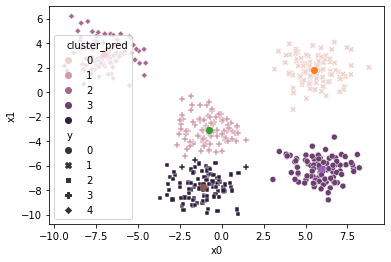

In [21]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

# generating synthetic data from isotropic Gaussian distributions (synthetic = imaginäre/künstliche daten)
X, y = make_blobs(n_features=2, n_samples=500, centers = 5) #samples = anzahl imaginäre random daten, X=features

kmeans = KMeans(n_clusters=5)

cluster_pred = kmeans.fit_predict(X)

cluster_df = pd.DataFrame({
    "x0": X[:, 0],
    "x1": X[:, 1],
    "y": y,
    "cluster_pred": cluster_pred
})

sns.scatterplot(
    x="x0",
    y="x1",
    style="y",
    hue="cluster_pred",
    data=cluster_df
)

# Draw centroids
for centroid in kmeans.cluster_centers_:
    plt.scatter(*centroid)

We can also apply KMeans to our dataset to check if we can find our topics without external labels.

Again we'll use the word frequencies as features.

In [22]:
from sklearn.cluster import KMeans

kmeans = KMeans(
    n_clusters=3,  # Fortunately, we know how many groups there are
    n_init=20,  # We want to compute 20 different clustering and choose the best one
)

kmeans.fit(np.asarray(freqs))
clusters_prediction = kmeans.predict(np.asarray(freqs))

articles_dataset["cluster_prediction"] = clusters_prediction
articles_dataset["cluster_prediction"].value_counts()

1    52
2    36
0     6
Name: cluster_prediction, dtype: int64

#### Evaluation of clustering


Evaluating clustering can be tricky because, in settings where we apply clustering, we usually have limited to no external data to see if our clusters correspond to meaningful and coherent groups.

Often, you'll need to check them manually and incorporate any useful metadata you have to check if the clustering can be useful.

#### Internal validation

Depending on the type of clustering algorithm there might be some metrics to internally validate the different clustering of the same data.

For example, to find a suitable $K$ for KMeans clustering, you can apply the [Silhoutte Score](https://en.wikipedia.org/wiki/Silhouette_(clustering)) to estimate a good value $K$.

But all those measures are only limited to checking certain general and broad assumptions on how a good clustering would look like without being able to account for your specific data.

#### External validation

If you happen to have (at least a small amount of labels), you can employ external validation metrics to check the quality of your clustering.

These measures quantify the overlap between the ground-truth clustering (=> labels) and the inferred clustering.

#### Epistemological considerations: Can we even evaluate exploration results?

Clustering is about finding interesting groups within your data, so even if you happen to have ground truth data, a clustering that does not follow those inductive categories might not be useless or wrong.

Your clustering might reveal different groups or categories that are simply not reflected by your labels.

For example, if we used different features on our Wikipedia dataset we might have found clusters that capture a notion of theoretical vs. empirical subfields, dividing the articles on both biology and computer science based on whether they are concerned with theoretical or empirical questions.

So if you explicitly use clustering for exploring your data, always check your clusters manually and use a battery of different algorithms, hyperparameters and features.

If you see stable patterns emerge throughout a large number of different clustering, you can be fairly sure you found something worthy of further investigation.


<br>

Leaving any of those considerations aside, and just to check if our methodology works, we use the Adjusted Rand Score to externally evaluate our clustering:

In [23]:
pd.set_option('display.max_rows', None)
articles_dataset[["title", "text", "topic", "cluster_prediction"]] #ergebnis: cluster-zuweisung - gehört am ehesten zu bio oder cs

,title,text,topic,cluster_prediction
0,Geology,"Geology (from Ancient Greek γῆ (gê) 'earth', ...",biology,1
1,Molecular biology,Molecular biology is the branch of biology th...,biology,1
2,Family (biology),"Family (Latin: familia, plural familiae) is on...",biology,1
3,Taxonomy (biology),"In biology, taxonomy (from Ancient Greek τάξι...",biology,1
4,Cell (biology),The cell is the basic structural and functiona...,biology,1
5,Domain (biology),"In biological taxonomy, a domain ( or ) (Latin...",biology,1
6,Evolutionary biology,Evolutionary biology is the subfield of biolog...,biology,1
7,Order (biology),Order (Latin: ordo) is one of the eight major ...,biology,1
8,Cell biology,Cell biology (also cellular biology or cytolog...,biology,1
9,Organ (biology),"In biology, an organ is a collection of tissue...",biology,1


In [24]:
from sklearn.metrics import adjusted_rand_score #the higher the better

ari = adjusted_rand_score(articles_dataset["topic"], articles_dataset["cluster_prediction"])
ari

0.6276097460068855

In [25]:
articles_dataset.query("(topic == 'cs' and cluster_prediction != 1 and cluster_prediction != 2) or (topic == 'biology' and cluster_prediction != 0)")
#query: filter nach bestimmten strings (hier: cs und bio)

,url,title,summary,text,num_views,num_edits,categories,revision_id,topic,cluster_prediction
0,https://en.wikipedia.org/wiki/Geology,Geology,"Geology (from Ancient Greek γῆ (gê) 'earth', ...","Geology (from Ancient Greek γῆ (gê) 'earth', ...",4234884,3290,"All articles with failed verification, Article...",1134347625,biology,1
1,https://en.wikipedia.org/wiki/Molecular_biology,Molecular biology,Molecular biology is the branch of biology th...,Molecular biology is the branch of biology th...,2143110,1453,"Articles with BNE identifiers, Articles with B...",1124222343,biology,1
2,https://en.wikipedia.org/wiki/Family_(biology),Family (biology),"Family (Latin: familia, plural familiae) is on...","Family (Latin: familia, plural familiae) is on...",2773053,921,"Articles containing French-language text, Arti...",1133677852,biology,1
3,https://en.wikipedia.org/wiki/Taxonomy_(biology),Taxonomy (biology),"In biology, taxonomy (from Ancient Greek τάξι...","In biology, taxonomy (from Ancient Greek τάξι...",9881050,3868,"All articles lacking reliable references, All ...",1133363688,biology,1
4,https://en.wikipedia.org/wiki/Cell_(biology),Cell (biology),The cell is the basic structural and functiona...,The cell is the basic structural and functiona...,9210652,4701,"1665 in science, Articles containing Latin-lan...",1133996848,biology,1
5,https://en.wikipedia.org/wiki/Domain_(biology),Domain (biology),"In biological taxonomy, a domain ( or ) (Latin...","In biological taxonomy, a domain ( or ) (Latin...",2315088,783,"Articles with short description, Domains (biol...",1125372452,biology,1
6,https://en.wikipedia.org/wiki/Evolutionary_bio...,Evolutionary biology,Evolutionary biology is the subfield of biolog...,Evolutionary biology is the subfield of biolog...,1028819,862,"Articles with GND identifiers, Articles with J...",1134337348,biology,1
7,https://en.wikipedia.org/wiki/Order_(biology),Order (biology),Order (Latin: ordo) is one of the eight major ...,Order (Latin: ordo) is one of the eight major ...,1656132,699,"All articles needing additional references, Al...",1134321842,biology,1
8,https://en.wikipedia.org/wiki/Cell_biology,Cell biology,Cell biology (also cellular biology or cytolog...,Cell biology (also cellular biology or cytolog...,2671431,1536,"All articles with unsourced statements, Articl...",1133003691,biology,1
9,https://en.wikipedia.org/wiki/Organ_(biology),Organ (biology),"In biology, an organ is a collection of tissue...","In biology, an organ is a collection of tissue...",1224820,2016,"All articles to be expanded, All articles with...",1132774654,biology,1


In [26]:
print(articles_dataset.query("title == 'Competition'").iloc[0].text[:2000]) 
#iloc greift über [0] aufs erste dok zu, text[:index] schränkt ein auch 2000 zeichen

Competition is a rivalry where two or more parties strive for a common goal which cannot be shared: where one's gain is the other's loss (an example of which is a zero-sum game). Competition can arise between entities such as organisms, individuals, economic and social groups, etc. The rivalry can be over attainment of any exclusive goal, including recognition:
Competition occurs in nature, between living organisms which co-exist in the same environment. Animals compete over water supplies, food, mates, and other biological resources. Humans usually compete for food and mates, though when these needs are met deep rivalries often arise over the pursuit of wealth, power, prestige, and fame when in a static, repetitive, or unchanging environment. Competition is a major tenet of market economies and business, often associated with business competition as companies are in competition with at least one other firm over the same group of customers. Competition inside a company is usually stimu

We can see that the inferred clustering matches the topics reasonably well, and judging by the titles of the "miss-clustered" article, the errors seem understandable since it is about a topic that draws inspiration from biology.

## DBScan

Instead of trying to find a fixed set of synthetic centroids representing a cluster, DBScan takes a completely different approach to identify clusters:

It searches the vector space for regions of high density (i.e., regions where many data points lie close together) and defines those regions as clusters.

<br>

Compared to KMeans it has several advantages that make it attractive:
- Due to its reliance on the euclidian distance, KMeans only finds clusters of spherical shape, whereas DBScan can find clusters of many shapes
- DBScan can infer the number of clusters automatically
- Additionally, DBScan also differentiates points within clusters from "noise" (=> points that do not belong in any cluster)

Let's compare DBScan and KMeans on synthetic data:

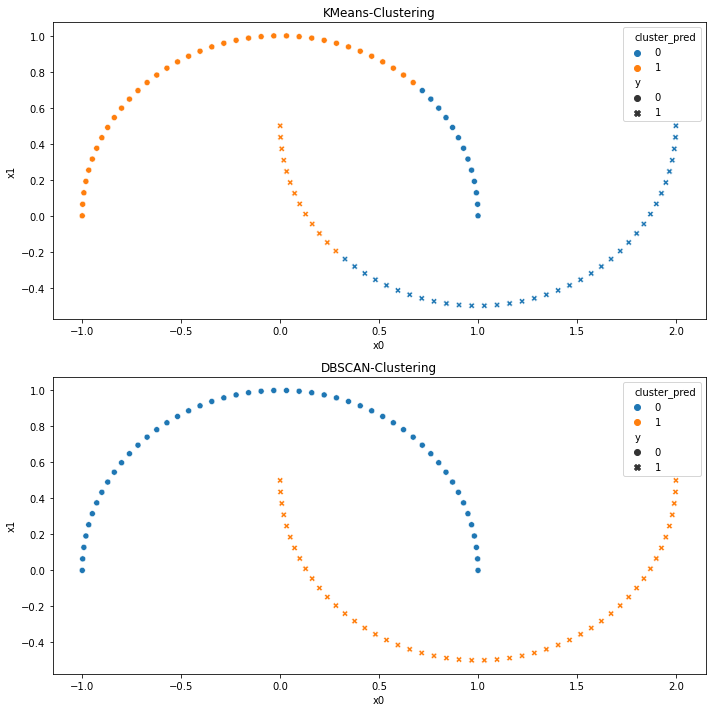

In [27]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.datasets import make_moons #moon shaped clusters

X, y = make_moons(n_samples=100)

kmeans = KMeans(n_clusters=2)
cluster_pred_kmeans = kmeans.fit_predict(X)

cluster_df_kmeans = pd.DataFrame({
    "x0": X[:, 0],
    "x1": X[:, 1],
    "y": y,
    "cluster_pred": cluster_pred_kmeans
})


dbscan = DBSCAN() #dbscan: no need to specify the clusters
cluster_df_dbscan = dbscan.fit_predict(X)

cluster_df_dbscan = pd.DataFrame({
    "x0": X[:, 0],
    "x1": X[:, 1],
    "y": y,
    "cluster_pred": cluster_df_dbscan
})

fig, axs = plt.subplots(2, 1, figsize=(10, 10))
sns.scatterplot(
    x="x0",
    y="x1",
    style="y",
    hue="cluster_pred",
    data=cluster_df_kmeans,
    ax=axs[0]
)
axs[0].set_title("KMeans-Clustering")

sns.scatterplot(
    x="x0",
    y="x1",
    style="y",
    hue="cluster_pred",
    data=cluster_df_dbscan,
    ax=axs[1]
)
axs[1].set_title("DBSCAN-Clustering")
plt.tight_layout()

While KMeans was not able to retrieve the original groups, DBScan achieved that even without stating any hyperparameter manually.


__But how does DBScan work?__

While the exact algorithm of DBScan isn't hard to understand it's relatively tedious to read and execute so we skip this part and only care about the details relevant to choose suitable hyperparameters.
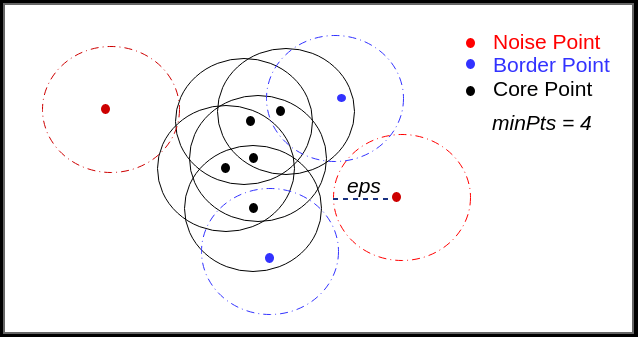

<p style="font-size: 8pt;">https://www.researchgate.net/publication/335485895/figure/fig2/AS:797412515909651@1567129367940/A-single-DBSCAN-cluster-with-Core-Border-and-Noise-Points.ppm</p>

DBscan assigns each point in the dataset to one of three classes:

* If a point has more $minPts$ or more neighbors within "radius" $eps$ around it, it is called a core point
* If it has less than $minPts$ neighbors within $eps$ but it is a neighbor of another core point it is called a border point
* If neither of those two conditions applies the point is called noise
  
To create a cluster DBScan randomly picks out a point of the dataset and starts if it's a core point it starts to expand the cluster until it has found all core or border points that are reachable from a chain of core and border points starting from the picked point.

In essence, you need to define the parameters $eps$, $minPts$ and optionally a distance function to control how DBScan finds clusters!

<br>

Again, let's find out what DBScan finds in our cluster

note: many points that show how dense our model is

In [28]:
dbscan = DBSCAN(
    eps=0.55, #change eps and min_samples to change the amount of clusters
    min_samples=6,
    metric="cosine" #auch andere möglich: z.b. manhatten, eucledian etc.
)

cluster_prediction_dbscan = dbscan.fit_predict(np.asarray(freqs))
articles_dataset["cluster_prediction_dbscan"] = cluster_prediction_dbscan
articles_dataset["cluster_prediction_dbscan"].value_counts()

-1    55
 2    22
 0    10
 1     7
Name: cluster_prediction_dbscan, dtype: int64

In [29]:
for cluster_idx in articles_dataset["cluster_prediction_dbscan"].unique(): #prints titles of our data set
    print(cluster_idx)
    print(*articles_dataset.query("cluster_prediction_dbscan == @cluster_idx").title, sep=" | ", end="\n\n")

-1
Geology | Family (biology) | Taxonomy (biology) | Domain (biology) | Evolutionary biology | Order (biology) | Organ (biology) | Hybrid (biology) | Kingdom (biology) | Conservation biology | Marine biology | Class (biology) | Mutualism (biology) | Endogeny (biology) | Polymorphism (biology) | Homology (biology) | Transcription (biology) | Translation (biology) | Geology | Stress (biology) | Division (biology) | Genomics | Feminization (biology) | Vespertine (biology) | Colony (biology) | Animal | Agglutination (biology) | Human biology | Colonisation (biology) | Cognitive biology | Ontology (computer science) | Heuristic (computer science) | Integer (computer science) | Macro (computer science) | Paxos (computer science) | Polymorphism (computer science) | String (computer science) | Lock (computer science) | Record (computer science) | Recursion (computer science) | State (computer science) | Garbage collection (computer science) | Semantics (computer science) | Consensus (computer 

The results shed a light on the drawbacks of DBScan: Even though we do not need to specify the number of clusters explicitly, we have to tune the other parameters carefully to find clusters, and even if we find some clusters chances are high that a lot of points get labeled as noise.

To overcome these stepping stones we - broadly spoken -  have two options:

* Carefully tuning the hyperparameter using techniques like grid-search (we cover that in the next sessions)
* Usually, it helps to use more dense features, like PCA projected frequencies or embeddings (we cover that DataScience 2)

## Hierarchical clustering
Although partially deeply connected to distance-based clustering methods like KMeans, hierarchical clustering does not aim at returning a fixed clustering rather it sorts all data point to a similarity-based hierarchy from which many clusters can be derived.

This is particularly useful when working on smaller datasets because it enables you to quickly get a global overview of your data.

Its algorithm is straightforward:

```
1. Initially each data point is a cluster in its own.
2. While not all data points belong to the same cluster, repeat:
3.      Find the two clusters with minimal distance two each other, and merge them to one cluster.
```

As you can guess from the algorithm, this method also does not have many hyperparameters, which makes it quite robust.

The two decisions you have to make are:
 * Choosing a distance metric
 * Deciding how to measure the distance between two clusters (i.e., sets of points)
  
There are three strategies to measure the distance between clusters:
* Single linkage: The distance between two clusters is the minimal distance between any two points of both clusters
* Complete linkage: The distance between two clusters is the maximum distance between any two points of both clusters
* Average linkage/ Ward-linkage: The distance between two clusters is the average distance between all points of both clusters

note: hirarichally clustering things together

Instead of returning a single clustering, hierarchical clustering returns a hierarchy of clusters.

Often this hierarchy is visualized as dendrogram.

Let's compute the dendrogram for our wiki dataset:



In [30]:
from sklearn.cluster import AgglomerativeClustering

agglom = AgglomerativeClustering(affinity="cosine", linkage="complete", n_clusters=1)

agglom.fit(np.asarray(freqs))

AgglomerativeClustering(affinity='cosine', linkage='complete', n_clusters=1)

In [31]:
#not so immportant!
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    distance = np.arange(model.children_.shape[0])

    linkage_matrix = np.column_stack(
        [model.children_, distance, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    return linkage_matrix

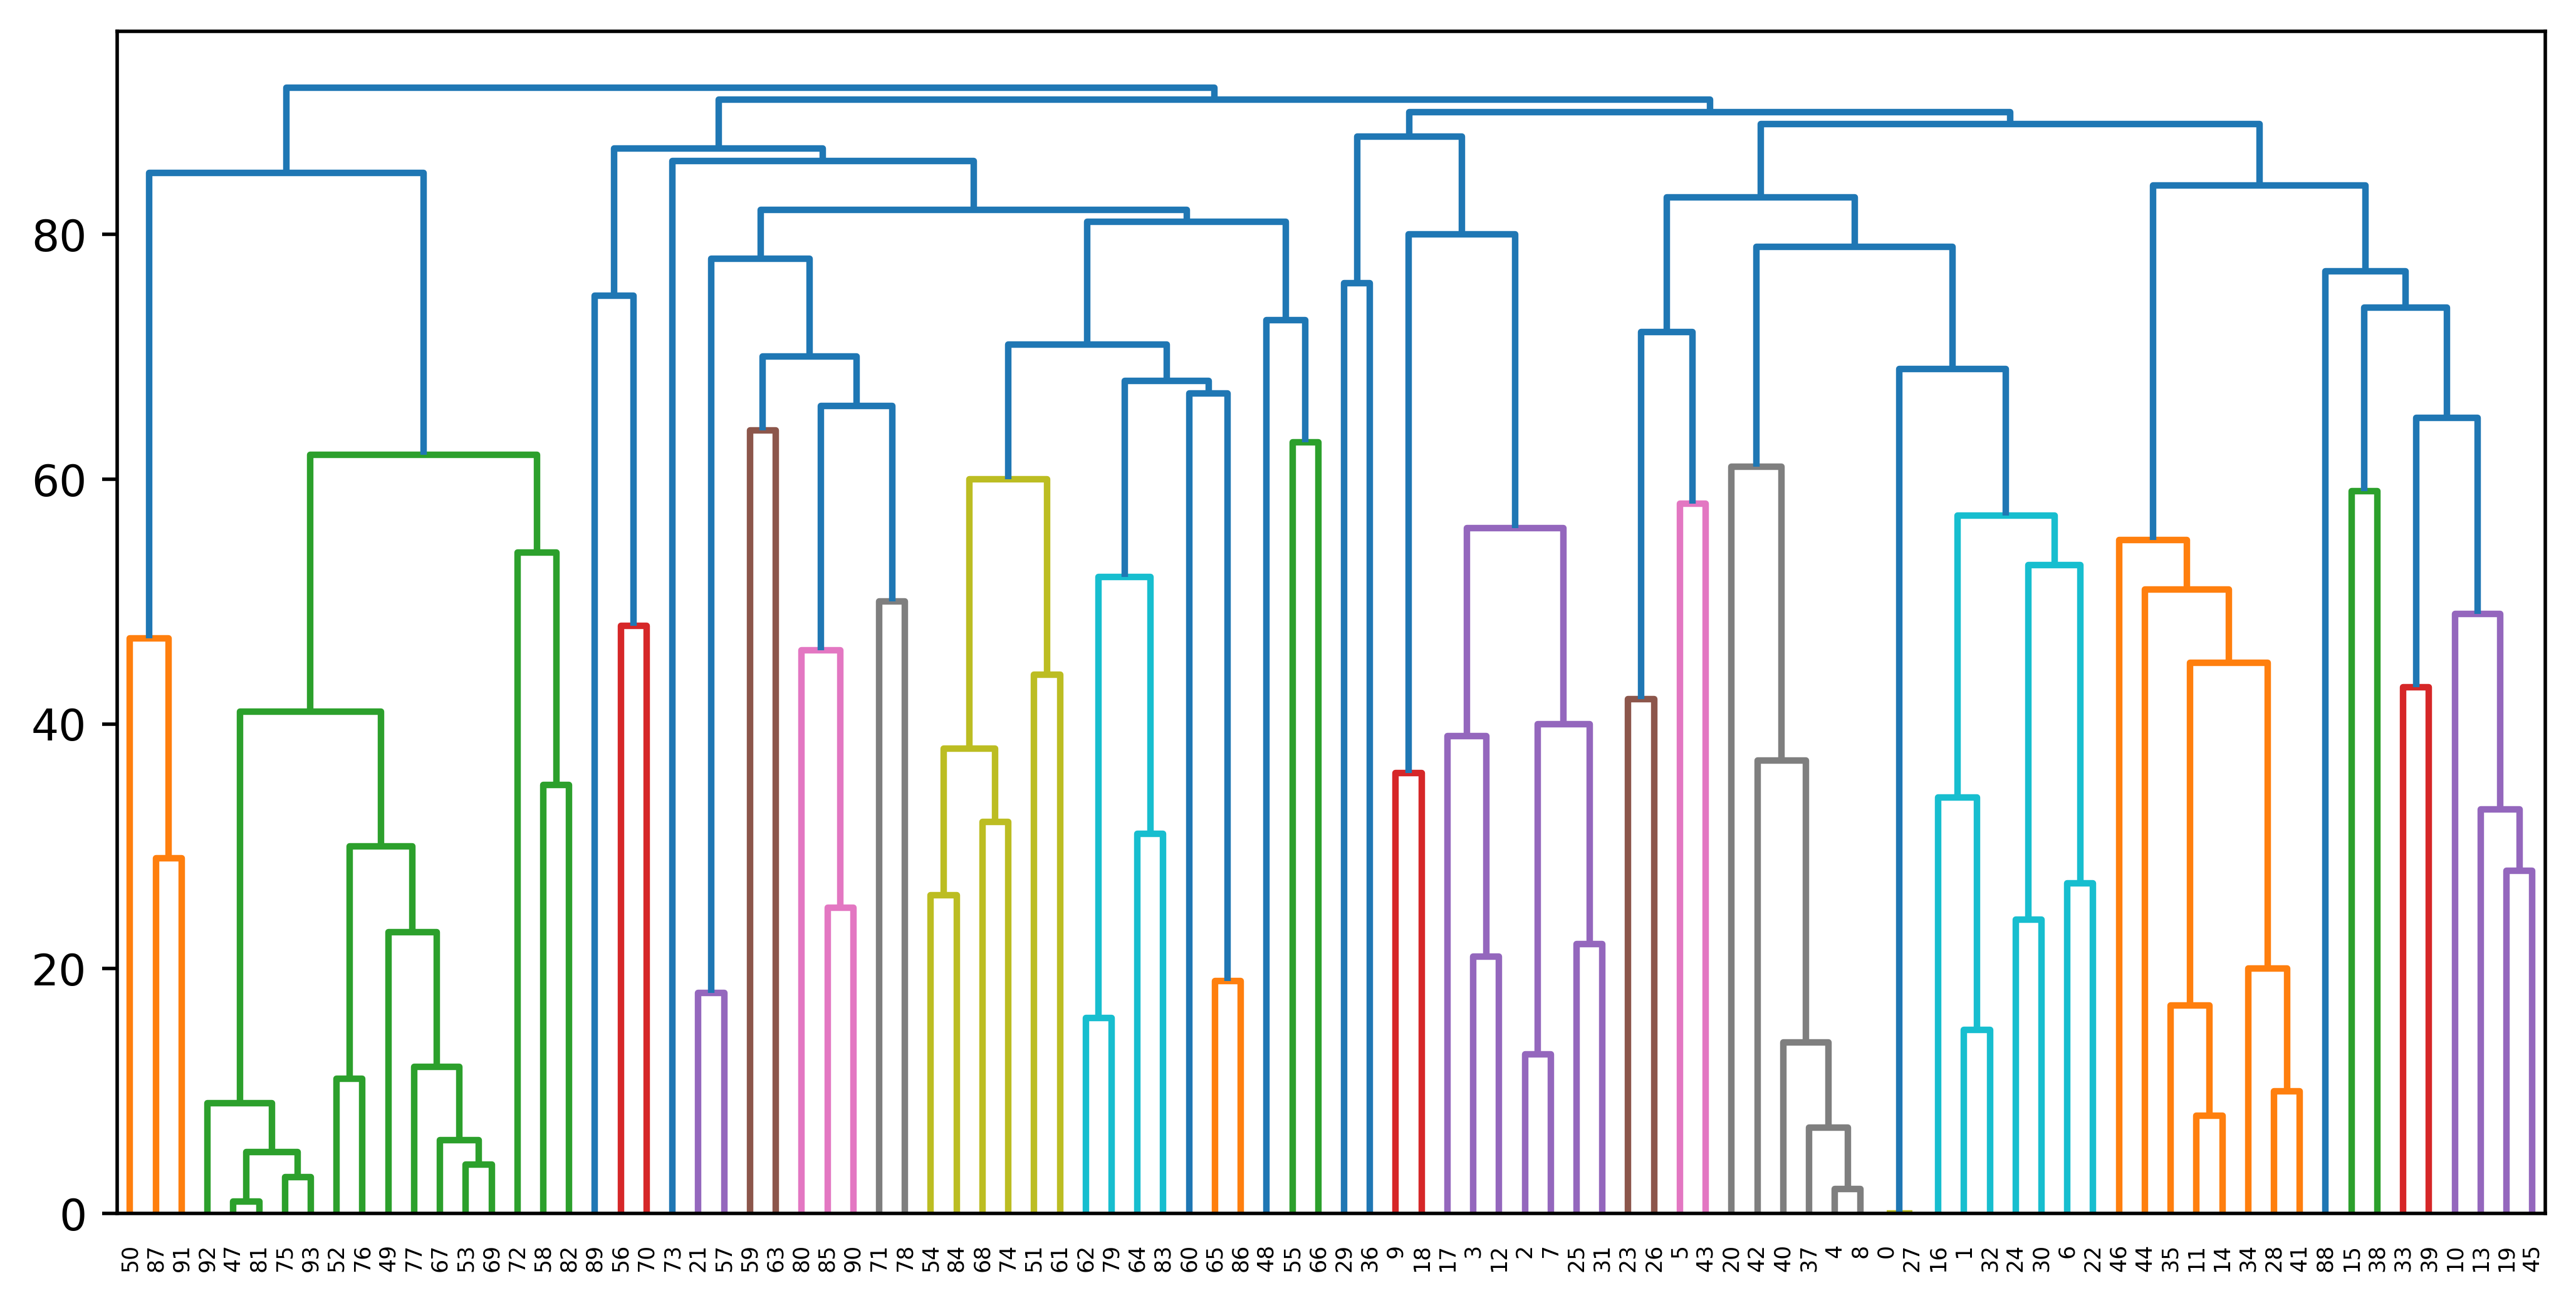

In [32]:
plt.subplots(figsize=(10, 5), dpi=500)
linkage_matrix = plot_dendrogram(agglom, truncate_mode="level", p=94)
plt.show()
#x axis: id of our articles
#0 and 26 are the closest
#colors: no special meaning
#closeness: ranges

The dendrogram visualizes the hierarchy of clusters as a tree, each leaf (i.e., an endpoint on the x-axis) represents a data point, and each vertical line represents a merge of two clusters.

Additionally, the height of the merges (where they are positioned on the y-axis) shows the distance between the clusters that were merged.

These properties make dendrogram a __really__ powerful tool for exploring your data globally.

Looking at your data that way often reveals interesting findings.

For example in the dendrogram for our dataset, we see that points 27 and 41 are merged relatively early but then get merged into another cluster pretty late.

Let's look at them in more detail:

In [36]:
doc1 = int(input())
doc2 = int(input())
articles_dataset.iloc[[doc1, doc2]] #check which are merged closest (cluster prediction must be equal)

26
10


,url,title,summary,text,num_views,num_edits,categories,revision_id,topic,cluster_prediction,cluster_prediction_dbscan
26,https://en.wikipedia.org/wiki/Translation_(bio...,Translation (biology),"In molecular biology and genetics, translation...","In molecular biology and genetics, translation...",2678460,1199,"Articles with short description, CS1 maint: ur...",1132553169,biology,1,-1
10,https://en.wikipedia.org/wiki/Hybrid_(biology),Hybrid (biology),"In biology, a hybrid is the offspring resultin...","In biology, a hybrid is the offspring resultin...",2730658,2343,"All articles with dead external links, All art...",1131612637,biology,1,-1


Both are about scientific journals in biology.  

##### Finding single (aka flat) clustering using Agglomerative Clustering

There are two simple ways to extract a single fixed clustering from an agglomerative clustering:

* Determining a maximum number of clusters
* Determining a minimum distance threshold between clusters.
  * Clusters lying further apart do not get merged.

Choosing one of these approaches depends on your specific use case.